In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
from definitions import get_node_id
import numpy as np
from SoftWL import compute_cluster_centroids, merge_close_clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances

In [2]:
iteration = 2
PhenoGraoh_k =  100
node_label = 'CellType'

In [103]:
# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
for file_name in FILE_NAMES:
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraoh_k)
            + ".npy",
        )
    )
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)

import pickle
SoftWL_dict= pickle.load(
        open(
            os.path.join(
                PROJECT_ROOT,
                "Output",
                "b_Soft_WL_Kernel_random_split",
                "Danenberg",
                "Subset_1",
                "SoftWL_dict_iter_"
                + str(iteration)
                + "_PhenoGraph_k_"
                + str(100)
                + "_"
                + node_label
                + ".pkl",
            ),
            "rb",
        ),
    )
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)
Patient_IDs = SoftWL_dict["Patient_id"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
clinical = process_Danenberg_clinical_data(clinical)
Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs])

In [4]:
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T

print("Signature shape: ", Signature.shape)

Signature shape:  (32, 66)


In [5]:
threshold = 0.5
tumor_niche = np.where(
    (np.sum(Signature[:16, :] > threshold, axis=0) > 0)
    & (np.sum(Signature[16:, :] > threshold, axis=0) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signature[:16, :] > threshold, axis=0) == 0)
    & (np.sum(Signature[16:27, :] > threshold, axis=0) > 0)
    & (np.sum(Signature[27:, :] > threshold, axis=0) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signature[:16, :] > threshold, axis=0) == 0)
    & (np.sum(Signature[16:27, :] > threshold, axis=0) == 0)
    & (np.sum(Signature[27:, :] > threshold, axis=0) > 0)
)[0]
interacting_niche = np.where(
    (np.sum(Signature[:16, :] > threshold, axis=0) > 0)
    & (np.sum(Signature[16:, :] > threshold, axis=0) > 0)
)[0]
print(tumor_niche, immune_niche, stromal_niche, interacting_niche)
print(len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche))

[ 2  3  4  5  8 10 12 14 15 16 17 19 21 23 24 25 30 33 34 37 38 43 44 45
 46 47 49 50 51 54 55 56 60 61 62 63 65] [ 0 20 58 64] [13 28 31 39 40 41 42 48 52 53 59] [ 7  9 18 22 26 27 29 32 35 36 57]
37 4 11 11


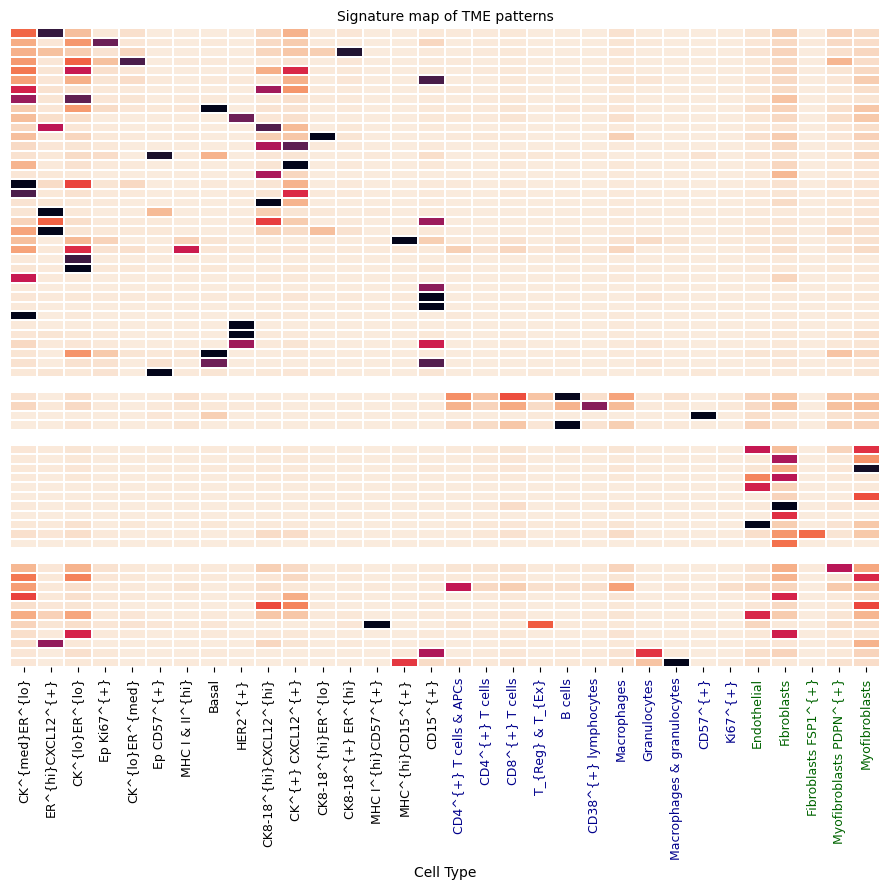

In [6]:

f, ax = plt.subplots(
    4,1,
    figsize=(9,9),
    gridspec_kw={
        "height_ratios": [
            len(tumor_niche),
            len(immune_niche),
            len(stromal_niche),
            len(interacting_niche),
        ]
    },
    sharex=True,
    tight_layout=True,
)
sns.heatmap(
    Signature[:, tumor_niche].T,
    ax=ax[0],
    cmap="rocket_r",
    linewidth=0.005,
     cbar=False,
    edgecolor="black",
    vmax=np.percentile(Signature, 99),
    vmin=np.percentile(Signature, 5),
)


sns.heatmap(
    Signature[:, immune_niche].T,
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    edgecolor="black",
    cbar=False,
    vmax=np.percentile(Signature, 99),
    vmin=np.percentile(Signature, 5),
)

sns.heatmap(
    Signature[:, stromal_niche].T,
    ax=ax[2],
    cmap="rocket_r",
     cbar=False,
    linewidth=0.005,
    edgecolor="black",
    vmax=np.percentile(Signature, 99),
    vmin=np.percentile(Signature, 5),
)

sns.heatmap(
    Signature[:, interacting_niche].T,
    ax=ax[3],
    cmap="rocket_r",
    linewidth=0.005,
     cbar=False,
    edgecolor="black",
    vmax=np.percentile(Signature, 99),
    vmin=np.percentile(Signature, 5),
)

ax[0].get_yaxis().set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_title("Signature map of TME patterns", fontsize=10)
ax[1].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
# ax[1].set_title("Immune Niche", fontsize=10)
ax[2].get_yaxis().set_visible(False)
ax[2].get_xaxis().set_visible(False)
# ax[2].set_title("Stromal Niche", fontsize=10)
ax[3].get_yaxis().set_visible(False)
# ax[3].set_title("Interacting Niche", fontsize=10)
from utils import reverse_dict
Cell_type_name_list = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(Centroids.shape[1])]
ax[3].set_xticklabels(Cell_type_name_list, rotation=90, fontsize=9)
ax[3].set_xlabel("Cell Type", fontsize=10)

xtickcolors = ["black"] * 16 + ["darkblue"] * 11 + ["darkgreen"] * 5
for xtick, color in zip(ax[3].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
plt.show()

In [7]:
import pandas as pd
DF = pd.DataFrame({})
index = 0
for i in range(Histograms.shape[0]):
    for j in range(Histograms.shape[1]):
        DF.loc[index, 'pattern_id'] = str(j)
        DF.loc[index, 'proportion'] = Histograms[i, j]
        index += 1


In [52]:
np.median(Histograms, axis=1)

array([2.36518448e-03, 2.42718447e-03, 0.00000000e+00, 1.45243282e-03,
       3.25732899e-03, 0.00000000e+00, 2.18499636e-03, 7.86266544e-04,
       1.65061898e-03, 1.09529025e-03, 1.99866755e-03, 1.18110236e-03,
       1.14854518e-03, 0.00000000e+00, 1.04144970e-04, 0.00000000e+00,
       1.07028184e-03, 2.52079657e-04, 1.60771704e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.88022065e-04, 1.18035883e-03, 8.30564784e-04, 0.00000000e+00,
       3.90015601e-04, 0.00000000e+00, 1.35135135e-03, 3.12500000e-04,
       7.22543353e-04, 2.35109718e-03, 2.08224883e-03, 2.10084034e-03,
       0.00000000e+00, 0.00000000e+00, 1.25817816e-03, 2.37154150e-03,
       2.33508465e-03, 0.00000000e+00, 1.11544897e-03, 1.21555916e-03,
       6.31711939e-04, 1.50829563e-03, 9.59692898e-04, 2.17812197e-03,
       7.86163522e-04, 7.27272727e-04, 9.08540279e-04, 0.00000000e+00,
       1.87149095e-04, 0.00000000e+00, 0.00000000e+00, 5.22193211e-04,
      

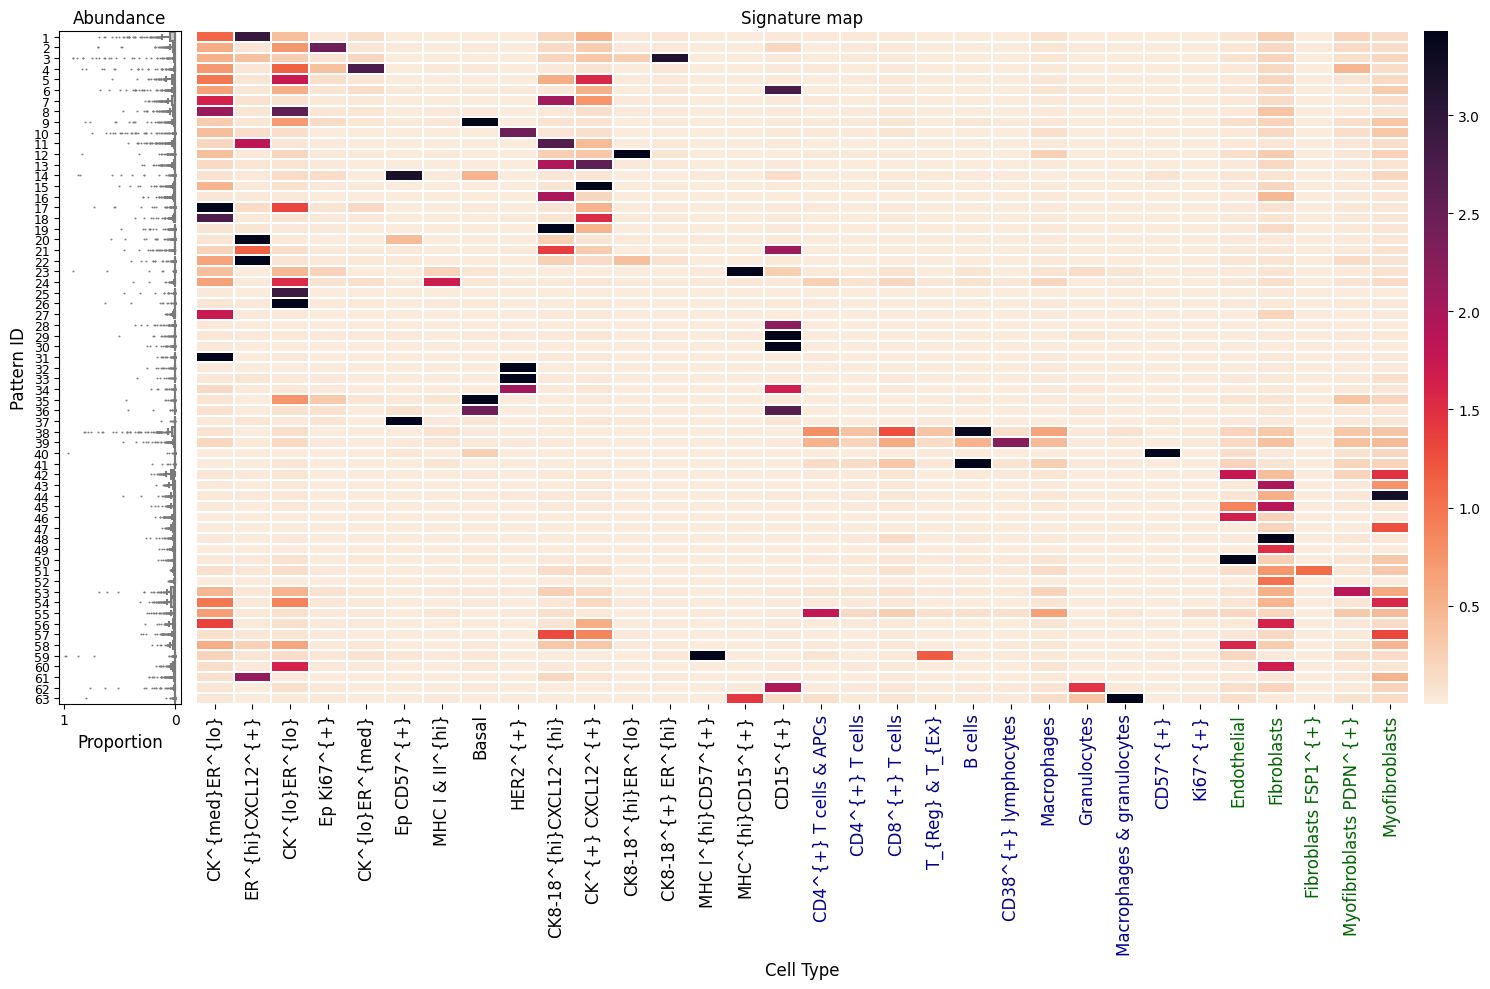

In [82]:
f, ax = plt.subplots(
    1,
    3,
    figsize=(15, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1,10,0.2]},
)
Signature_reorder = Signature[
    :, np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])
]
Indices = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])
sns.heatmap(
    Signature[:, Indices].T,
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signature, 99),
    vmin=np.percentile(Signature, 5),
)

ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=12)
from utils import reverse_dict

Cell_type_name_list = [
    reverse_dict(get_node_id("Danenberg", node_label))[i]
    for i in range(Centroids.shape[1])
]
ax[1].set_xticklabels(Cell_type_name_list, rotation=90, fontsize=12)

ax[1].set_xlabel("Cell Type", fontsize=12)
xtickcolors = ["black"] * 16 + ["darkblue"] * 11 + ["darkgreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(y="pattern_id", x="proportion", data=DF, showfliers=True, ax = ax[0], color='.8', order = [str(i) for i in Indices], fliersize=0.5)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=12)
ax[0].set_yticklabels([i+1 for i in range(len(Indices))], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=12)
ax[0].invert_xaxis()
plt.show()

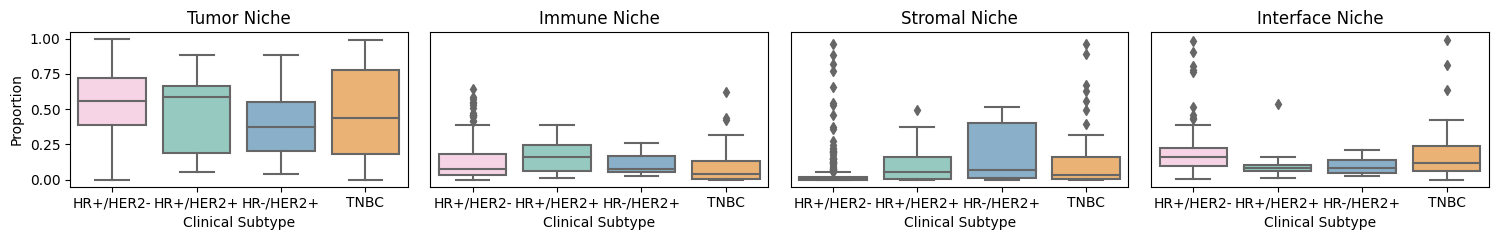

In [130]:
f, ax = plt.subplots(1,4, figsize=(15,2.5), tight_layout=True, sharey=True)
colors=   [sns.color_palette("Set3")[7],sns.color_palette("Set3")[0],sns.color_palette("Set3")[4] ,sns.color_palette("Set3")[5] ]  
order= ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']
DF = pd.DataFrame({
    'proportion': np.sum(Histograms[:, tumor_niche],  axis = 1),
    'Clinical_subtypes': Clinical_subtypes_
})
sns.boxplot(data = DF, x = 'Clinical_subtypes', y = 'proportion', ax = ax[0], order =order, palette =colors)
DF = pd.DataFrame({
    'proportion': np.sum(Histograms[:, stromal_niche],  axis = 1),
    'Clinical_subtypes': Clinical_subtypes_
})
sns.boxplot(data = DF, x = 'Clinical_subtypes', y = 'proportion', ax = ax[1],  order =order, palette =colors)

DF = pd.DataFrame({
    'proportion': np.sum(Histograms[:, immune_niche],  axis = 1),
    'Clinical_subtypes': Clinical_subtypes_
})
sns.boxplot(data = DF, x = 'Clinical_subtypes', y = 'proportion', ax = ax[2],  order =order, palette =colors)

DF = pd.DataFrame({
    'proportion': np.sum(Histograms[:, interacting_niche],  axis = 1),
    'Clinical_subtypes': Clinical_subtypes_
})
sns.boxplot(data = DF, x = 'Clinical_subtypes', y = 'proportion', ax = ax[3],  order =order, palette =colors)
ax[0].set_title("Tumor Niche", fontsize=12)
ax[0].set_xlabel("Clinical Subtype", fontsize=10)
ax[0].set_ylabel("Proportion", fontsize=10)
ax[1].set_title("Immune Niche", fontsize=12)
ax[1].set_xlabel("Clinical Subtype", fontsize=10)

ax[1].get_yaxis().set_visible(False)
ax[2].set_title("Stromal Niche", fontsize=12)
ax[2].set_xlabel("Clinical Subtype", fontsize=10)
ax[2].get_yaxis().set_visible(False)
ax[3].set_title("Interface Niche", fontsize=12)
ax[3].get_yaxis().set_visible(False)
ax[3].set_xlabel("Clinical Subtype", fontsize=10)
plt.show()

### Group patterns into biologically meaningful categories

In [5]:
# KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(Signature.T)
kmeans.labels_

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([ 8,  8, 15, 14,  8, 14,  8,  8, 14,  8,  2,  8, 19,  8, 14, 17,  8,
       19,  8,  8,  8, 19,  0,  8, 19, 19, 19,  8,  0, 16,  1,  8,  0, 11,
       19, 15,  2, 15,  2,  0,  8,  8,  0, 10,  8, 14, 14,  5,  0,  8,  2,
       12, 13,  8,  2, 11,  4,  9, 18,  0,  4,  2,  6, 17,  3,  7],
      dtype=int32)

In [6]:
Signature_ = []
for i in range(20):
    Signature_.append(Signature[:, kmeans.labels_ == i])
Signature_ = np.concatenate(Signature_, axis=1)


### Signature map 

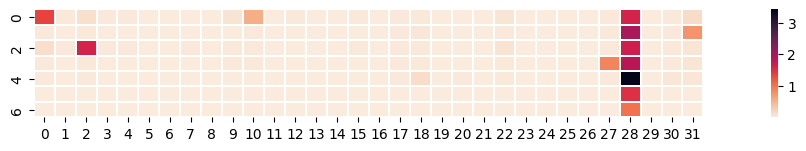

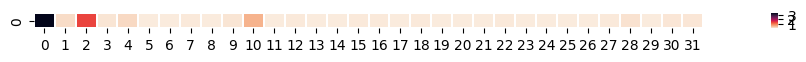

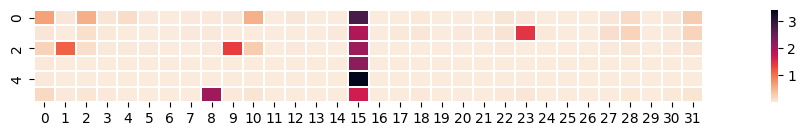

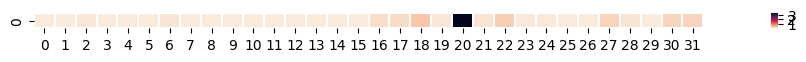

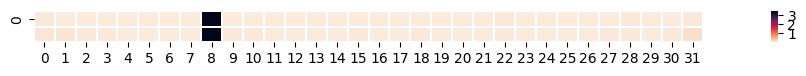

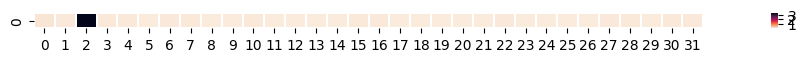

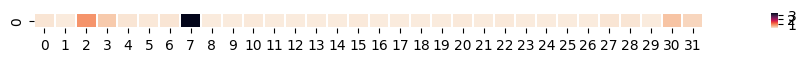

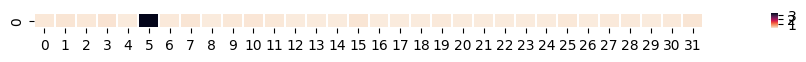

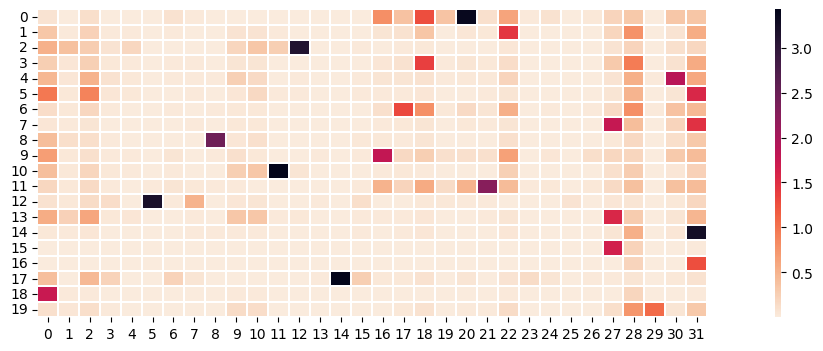

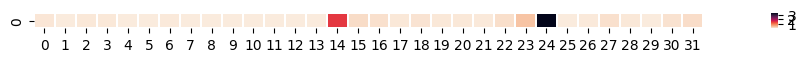

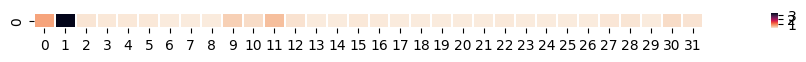

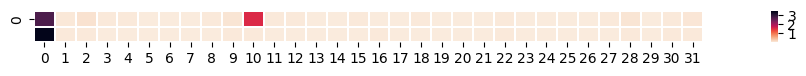

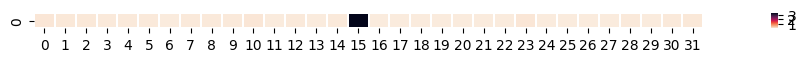

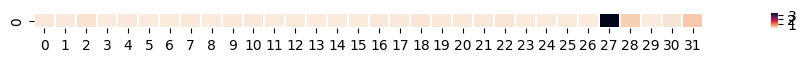

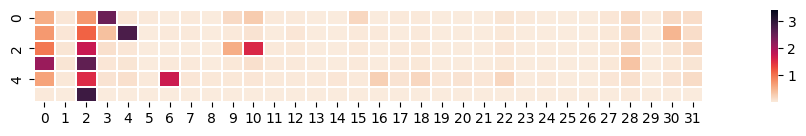

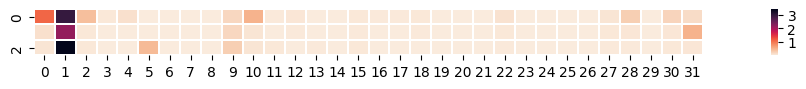

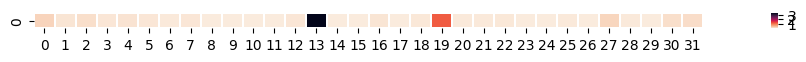

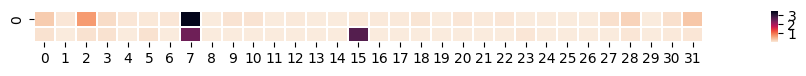

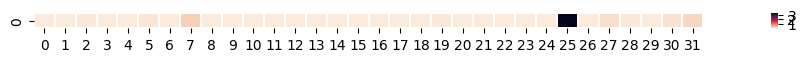

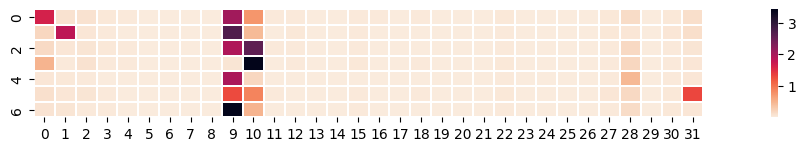

In [11]:
# Signature map before merging
# Centroids = compute_cluster_centroids(X, Cluster_identities)
# Signature = Centroids.T
if node_label == 'CellType':
    Node_label_list = list(get_node_id('Danenberg', node_label))
else:
    Node_label_list = ['tumor', 'immune', 'stroma']
for i in range(20):
    f, (ax, cbar_ax) = plt.subplots(1,2,figsize=( Signature.shape[0]*0.3, np.sum(kmeans.labels_ == i)*0.2),gridspec_kw= {"width_ratios": [20,0.2]} )
    sns.heatmap(
            Signature[:, kmeans.labels_ == i].T,
            ax=ax,
            cbar_ax=cbar_ax,
            cmap="rocket_r",
            linewidth=0.005,
            edgecolor="black",
            vmax=np.percentile(Signature, 99),
            vmin=np.percentile(Signature, 1),
        )
    # ax.set_yticklabels(Node_label_list, rotation=0, fontsize=20)
    # ax.set_xticklabels([i+1 for i in range(Signature.shape[1])], fontsize=10, rotation = 90)
    # ax.set_xlabel("TME pattern index", fontsize=20)
    # ax.set_title("Signature map before merging", fontsize=20)
    plt.show()


### Umap

In [7]:
# Umap before merging
from sklearn.manifold import TSNE
import umap.umap_ as umap

n_sample = 100000
indices_sampled = np.random.choice(X.shape[0], n_sample, replace=False)
X_sampled = X[indices_sampled]
Cluster_identities_sampled = Cluster_identities[indices_sampled]
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_sampled-np.mean(X_sampled, axis=0))


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/umap/distances.py:1086: 

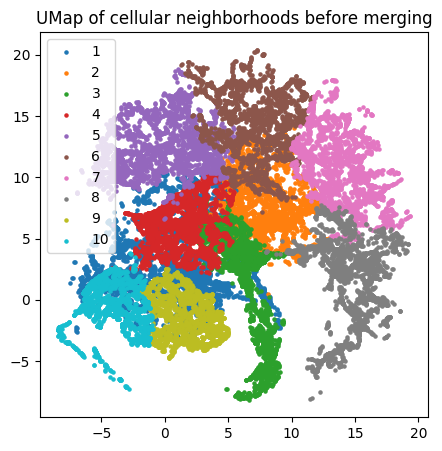

In [8]:
f, ax = plt.subplots(figsize = (5,5))
for i in range(10):
    ax.scatter(embedding[Cluster_identities_sampled == i,0], embedding[Cluster_identities_sampled == i,1], color = sns.color_palette('tab10')[i], s = 5, label = i+1)

ax.legend()
ax.set(title = 'UMap of cellular neighborhoods before merging')
f.show()

### Pairwose distance between centroids

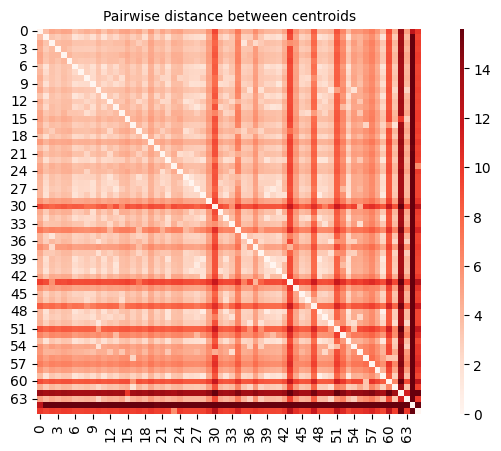

In [8]:
# Pirwise distance between centroids
pairwise_dist = pairwise_distances(Centroids)
f, (ax, cbar_ax) = plt.subplots(1,2,figsize=(5.5, 5),gridspec_kw= {"width_ratios": [20,0.2]} )
sns.heatmap(
        pairwise_dist,
        ax=ax,
        cbar_ax=cbar_ax,
        cmap="Reds",
        linewidth=0.0005,
        edgecolor="black",
        vmax=np.percentile(Centroids, 100),
        vmin=np.percentile(Centroids, 0),
    )
ax.set_title("Pairwise distance between centroids", fontsize=10)
plt.show()